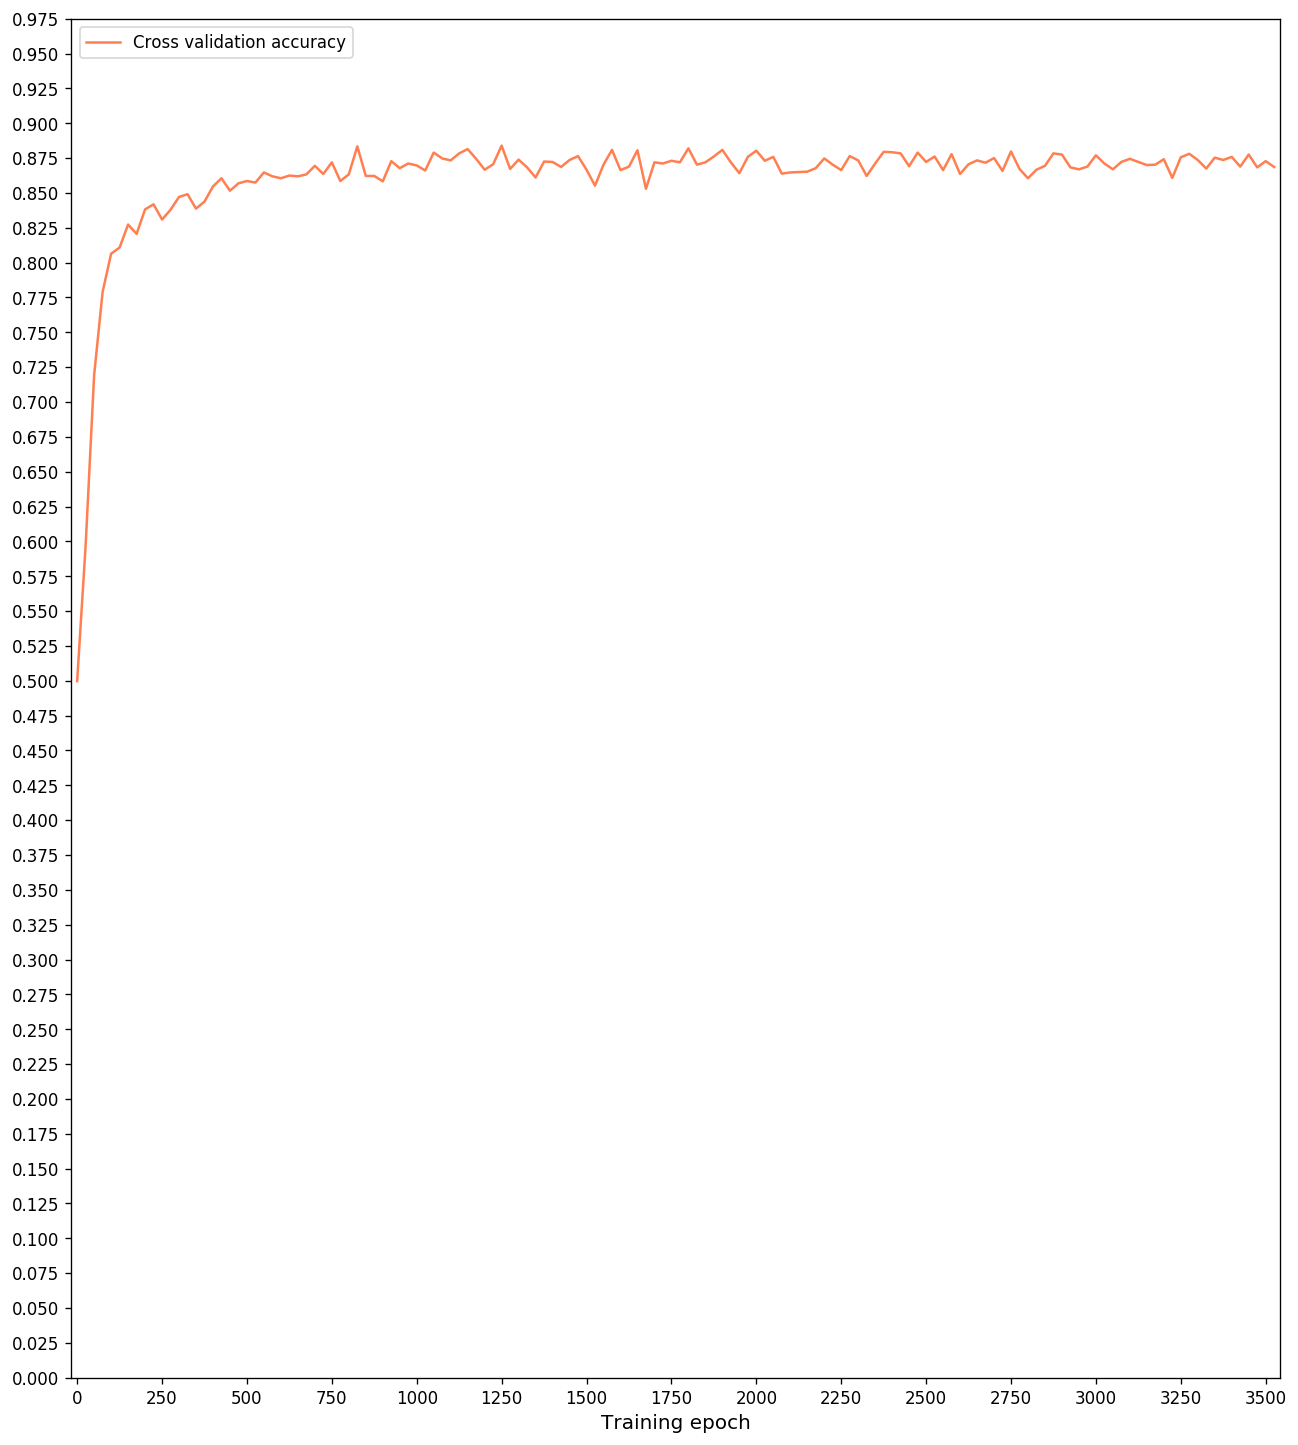

Cross validation accuracy: 0.871296037946


In [128]:
import matplotlib.pyplot as plt
import pylab as pb
import numpy as np
import collections
import csv
import sys
import os

DATA_ACCURACY_DIR_PATH = "./cross_validation"
DATA_LOSS_DIR_PATH = "./cross_validation"
POWER_TEST_DIR_PATH = "./power_test/results"

def get_files_in_dir(dir_path):
    files = [os.path.join(dir_path, file) for file in os.listdir(dir_path) if os.path.isfile(
                                                                    os.path.join(dir_path, file))]
    return files
    

def load_tensorflow_csv(csv_file_path):
    step_value_dict = collections.defaultdict(int)
    with open(csv_file_path, "rb") as csv_file:
        reader = csv.reader(csv_file, delimiter=",", quotechar="|")
        next(reader, None)
        for time, step, value in reader:
            step = int(step)
            value = float(value)
            step_value_dict[step] = value
        
    return step_value_dict


def get_max_key(dict):
    max_key = 0
    for key in dict:
        max_key = max_key if max_key > key else key
    
    return max_key


def get_cross_validation_data(dir_path):
    files = get_files_in_dir(dir_path)
    step_value_maps = [load_tensorflow_csv(file) for file in files]
    #print("{} maps created".format(len(step_value_maps)))
    max_keys = [get_max_key(step_value_map) for step_value_map in step_value_maps]
    end_map_key = min(max_keys)
    
    cross_validation_map = collections.defaultdict(float)
    for step_value_map in step_value_maps:
        for step_key in step_value_map:
            if step_key <= end_map_key:
                cross_validation_map[step_key] += step_value_map[step_key] / len(files)
    
    step_value_pairs = [(map_key, cross_validation_map[map_key]) for map_key in cross_validation_map]
    sorted_pairs = sorted(step_value_pairs, key=lambda tup: tup[0])
    steps = []
    values = []
    for step, value in sorted_pairs:
        steps.append(step)
        values.append(value)
    
    return steps, values


def plot_cross_validation(dir_path):
    steps, values = get_cross_validation_data(dir_path)
    # Everything's computed, time to draw some fancy stuff
    plt.figure(figsize=(13,15), dpi=120) # Plot dimensions
    plt.ylim(0.45,0.92) # Set range for y values
    handle, = plt.plot(steps, values, "-", color="coral", label="Cross validation accuracy")
    plt.xticks(np.arange(0, 9600+1, 250))
    plt.yticks(np.arange(0, 1.0, 0.025))
    plt.legend(handles=[handle], loc='upper left')
    plt.margins(0.005)
    plt.xlabel("Training epoch", fontdict=None, labelpad=None, fontsize=12)
    pb.savefig("cross_validation.png", bbox_inches='tight')
    plt.show()
    
    avg_accuracy = 0.0
    total_points = 0.0
    step_increment = 25
    total_steps = int(1000 / 25)
    for i in range(len(values)-1, len(values)-total_steps-1, -1):
        avg_accuracy += values[i]
        total_points += 1
    avg_accuracy /= total_points
    print("Cross validation accuracy: {}".format(avg_accuracy))


def plot_size_power_curves(dir_path):
    files = get_files_in_dir(dir_path)
    files = sorted(files)
    labels = [os.path.splitext(os.path.basename(file))[0] for file in files]
    step_value_maps = [load_tensorflow_csv(file) for file in files]
    step_value_pairs = []
    steps = []
    values = []
    for step_value_map in step_value_maps:
        current_pairs = [(map_key, step_value_map[map_key]) for map_key in step_value_map]
        sorted_pairs = sorted(current_pairs, key=lambda tup: tup[0])
        step_value_pairs.append(sorted_pairs)
    
    for current_pairs in step_value_pairs:
        current_steps = [current_pair[0] for current_pair in current_pairs]
        current_values = [current_pair[1] for current_pair in current_pairs]
        steps.append(current_steps)
        values.append(current_values)
    
    # Everything's computed, time to draw some fancy stuff
    plt.figure(figsize=(20,15), dpi=120) # Plot dimensions
    plt.ylim(0.45,0.93) # Set range for y values
    plt.xticks(np.arange(0, 9600+1, 250))
    plt.yticks(np.arange(0, 1.0, 0.025))
    plt.margins(0.005)
    plt.xlabel("Training epoch", fontdict=None, labelpad=None, fontsize=12)
    
    handles = []
    for i in range(0, len(steps)):
        handle, = plt.plot(steps[i], values[i], label=labels[i], color=None)
        handles.append(handle) 
    
    plt.legend(handles=handles, loc='upper left')
    pb.savefig("size_power.png", bbox_inches='tight')
    plt.show()
    

def plot_size_power_points(dir_path):
    files = get_files_in_dir(dir_path)
    labels = [os.path.splitext(os.path.basename(file))[0] for file in files]
    percents = [int(label.split("_")[1]) for label in labels]
    file_percent_pairs = zip(files, percents)
    file_percent_pairs = sorted(file_percent_pairs, key=lambda tup: tup[1])
    files = [file for (file, percent) in file_percent_pairs]
    percents = [percent for (file, percent) in file_percent_pairs]
    step_value_maps = [load_tensorflow_csv(file) for file in files]
    avg_points = []
    for step_value_map in step_value_maps:
        current_pairs = [(map_key, step_value_map[map_key]) for map_key in step_value_map]
        sorted_pairs = sorted(current_pairs, key=lambda tup: tup[0])
        avg_accuracy = 0.0
        total_points = 0.0
        step_increment = 25
        total_steps = int(500 / 25)
        for i in range(len(sorted_pairs)-1, len(sorted_pairs)-total_steps-1, -1):
            avg_accuracy += sorted_pairs[i][1]
            total_points += 1
        avg_accuracy /= total_points
        print("avg_accuracy: {}".format(avg_accuracy))
        avg_points.append(avg_accuracy)
    
    # Everything's computed, time to draw some fancy stuff
    plt.figure(figsize=(15,15), dpi=120) # Plot dimensions
    plt.ylim(0.0,0.93) # Set range for y values
    plt.xticks(np.arange(0, 100+1, 5))
    plt.yticks(np.arange(0, 1.0, 0.025))
    plt.margins(0.015)
    plt.xlabel("Training set size in %", fontdict=None, labelpad=None, fontsize=12)
    plt.ylabel("Accuracy", fontdict=None, labelpad=None, fontsize=12)
    
    handles = []
    handle, = plt.plot(percents, avg_points, "o", color="coral", ms=10, label="Evaluated set size")
    
    plt.plot(percents, avg_points, "--", color="coral")
    
    plt.legend(handles=[handle], loc='upper left')
    pb.savefig("size_power_points.png", bbox_inches='tight')
    plt.show()


plot_cross_validation(DATA_ACCURACY_DIR_PATH)
#plot_size_power_points(POWER_TEST_DIR_PATH)
    